In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from astropy.io import fits
import fitsio

In [3]:
import lightkurve as lk
from scipy import stats
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import simple_norm

In [24]:
from roman_lcs import Machine, RomanMachine

In [17]:
PATH = "/Users/jimartin/Work/ROMAN/simulations/run_v0.2"

In [18]:
ff = sorted(os.listdir(f"{PATH}/imgs"))
ff = [f"{PATH}/imgs/{x}" for x in ff]
len(ff)

6702

In [19]:
ff[:2]

['/Users/jimartin/Work/ROMAN/simulations/run_v0.2/imgs/rimtimsim_WFI_rampfitted_F146_SCA01_field01_ramp_subframe_0250x0250_20270214T0013_sim.fits',
 '/Users/jimartin/Work/ROMAN/simulations/run_v0.2/imgs/rimtimsim_WFI_rampfitted_F146_SCA01_field01_ramp_subframe_0250x0250_20270214T0025_sim.fits']

In [10]:
catalog = pd.read_csv(f"{PATH}/mean_input_catalog.txt", index_col=0)
catalog["flux"] = 10 ** ((27.53861667037689 - catalog["F146"])/2.5)
catalog["flux_err"] = np.sqrt(catalog["flux"])
catalog

,sicbroid,xcol,ycol,F146,ra_deg,dec_deg,flux,flux_err
-1,0,125.000000,125.000000,17.000,268.279268,-28.746497,16422.779737,128.151394
0,1,175.281640,217.529604,20.717,268.282355,-28.744864,535.360923,23.137868
1,2,69.039869,140.004071,24.701,268.277838,-28.745248,13.647298,3.694225
2,3,24.095405,52.197116,23.149,268.274992,-28.746840,56.996301,7.549589
3,4,151.019019,217.089188,23.617,268.281617,-28.744503,37.037927,6.085879
...,...,...,...,...,...,...,...,...
18545,18546,49.219505,94.403485,24.868,268.276466,-28.746129,11.701638,3.420766
18546,18547,2.039745,110.334565,25.123,268.275317,-28.744991,9.252235,3.041749
18547,18548,91.446810,21.156735,24.298,268.276492,-28.748681,19.780928,4.447576
18548,18549,194.216412,91.312406,23.769,268.280779,-28.748435,32.199318,5.674444


In [27]:
sources = catalog.query("F146 < 21")
sources = sources.rename(columns={"ra_deg": "ra", "dec_deg": "dec", "xcol": "column", "ycol": "row"})
sources

,sicbroid,column,row,F146,ra,dec,flux,flux_err
-1,0,125.000000,125.000000,17.000,268.279268,-28.746497,16422.779737,128.151394
0,1,175.281640,217.529604,20.717,268.282355,-28.744864,535.360923,23.137868
4,5,208.192458,79.438460,19.243,268.280998,-28.748958,2080.878237,45.616644
24,25,193.979337,105.265561,20.793,268.281009,-28.748069,499.167922,22.342066
31,32,225.556490,69.568893,20.910,268.281353,-28.749481,448.174010,21.170121
...,...,...,...,...,...,...,...,...
18465,18466,155.160154,30.841295,20.751,268.278575,-28.749407,518.855791,22.778406
18479,18480,179.040602,73.442134,20.845,268.280018,-28.748666,475.824356,21.813399
18481,18482,126.902694,152.644854,15.671,268.279795,-28.745808,55853.020971,236.332437
18506,18507,10.192706,91.303237,19.849,268.275238,-28.745611,1190.821503,34.508282


# PSFMachine

In [101]:
mac = RomanMachine.from_file(
    ff[:10], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux"
)

Creating delta arrays: 100%|█████████████████████████████████████████████████████████████| 1698/1698 [00:00<00:00, 2644.33it/s]
/Users/jimartin/Work/ROMAN/Roman-lcs/src/roman_lcs/machine.py:370: RuntimeWarning: All-NaN slice encountered
  max_flux = np.nanmax(self.flux[self.time_mask], axis=0)


In [102]:
mac

RomanMachine (N sources, N times, N pixels): (1698, 10, 62500)

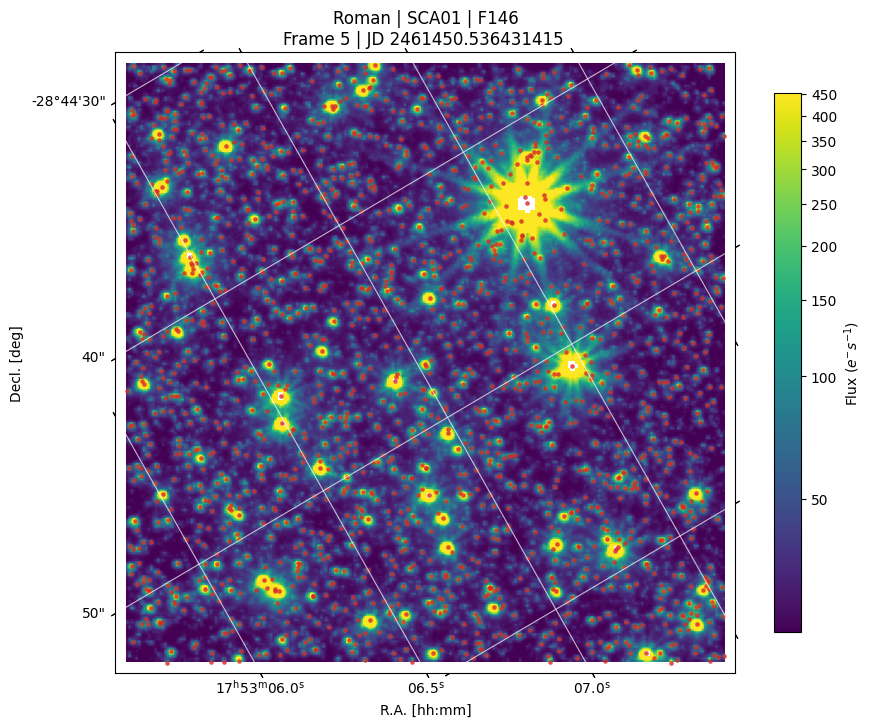

In [103]:
mac.plot_image(sources=True, frame_index=5);

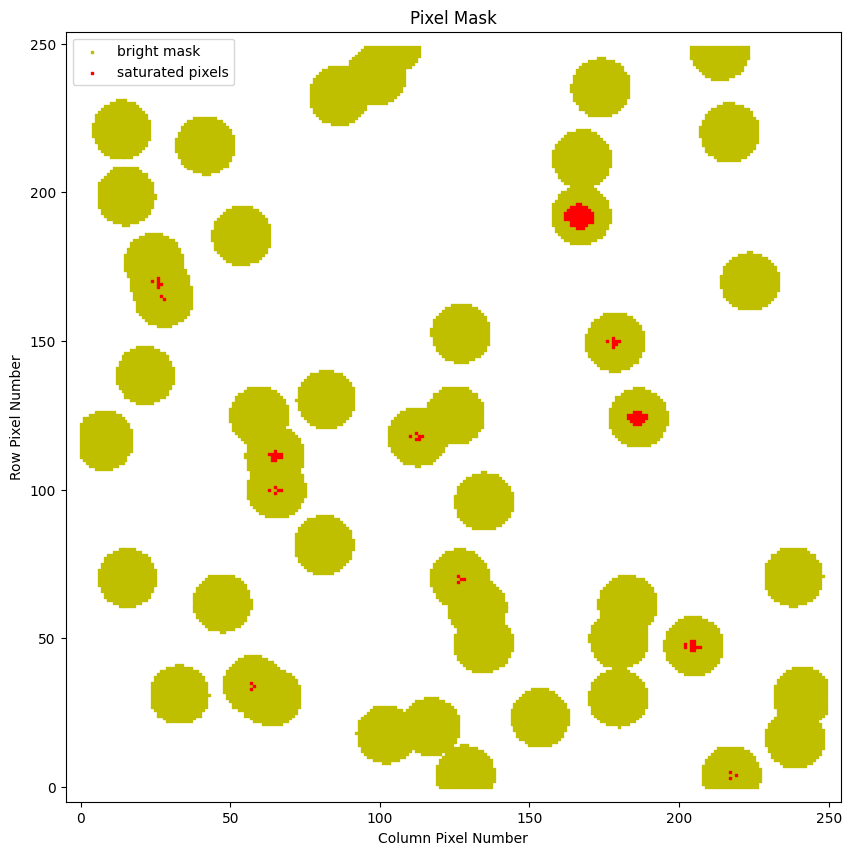

In [104]:
mac._mask_pixels(magnitude_bright_limit=17)
_ = mac.plot_pixel_masks()

In [105]:
mac._pointing_offset

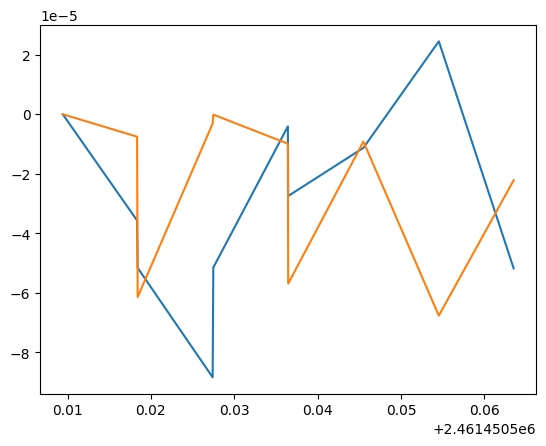

In [108]:
plt.plot(mac.time, mac.ra_offset)
plt.plot(mac.time, mac.dec_offset)